In [31]:
dataset = "dataset02"

In [35]:
import os
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

import yaml

def load_class_names(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    # Handle both list or dict formats
    if isinstance(data['names'], dict):
        class_names = [data['names'][i] for i in sorted(data['names'])]
    else:
        class_names = data['names']
    return class_names

IMAGE_DIR = f'{dataset}/val/images'
LABEL_DIR = f'{dataset}/val/labels'

YAML_PATH = f'{dataset}/data.yaml'  # or wherever your .yaml file is
CLASS_NAMES = load_class_names(YAML_PATH)
print(CLASS_NAMES)

['orange_cone', 'unknown_cone', 'yellow_cone', 'large_orange_cone', 'other']


In [ ]:
class_counts = defaultdict(int)
class_examples = defaultdict(list)

# Parse annotations and collect counts + examples
for label_file in os.listdir(LABEL_DIR):
    if not label_file.endswith('.txt'):
        continue
    label_path = os.path.join(LABEL_DIR, label_file)
    image_name = os.path.splitext(label_file)[0] + '.jpg'
    image_path = os.path.join(IMAGE_DIR, image_name)

    if not os.path.exists(image_path):
        continue

    with open(label_path, 'r') as f:
        for line in f:
            cls_id = int(line.strip().split()[0])
            class_counts[cls_id] += 1
            if len(class_examples[cls_id]) < 3:
                class_examples[cls_id].append((image_path, line.strip()))

total_cones = 0
for c in class_counts: 
    total_cones += class_counts[c] 

for i, cls in enumerate(CLASS_NAMES):
    print(f"Class {i} - {cls}: {class_counts[i]} occurences ({round(class_counts[i]/total_cones, 2)*100}%)")

print(f"Total: {total_cones}")

Class 0 - orange_cone: 2383 occurences (35.0%)
Class 1 - unknown_cone: 2783 occurences (41.0%)
Class 2 - yellow_cone: 1088 occurences (16.0%)
Class 3 - large_orange_cone: 423 occurences (6.0%)
Class 4 - other: 134 occurences (2.0%)


Class 1 (unknown_cone): 2783 occurrences


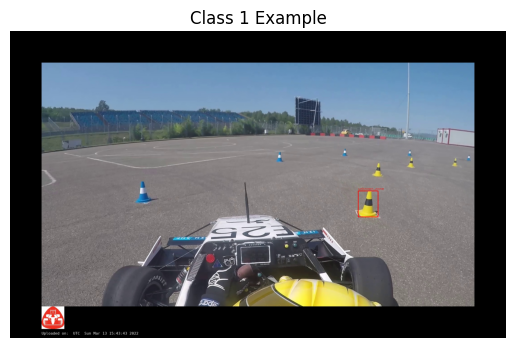

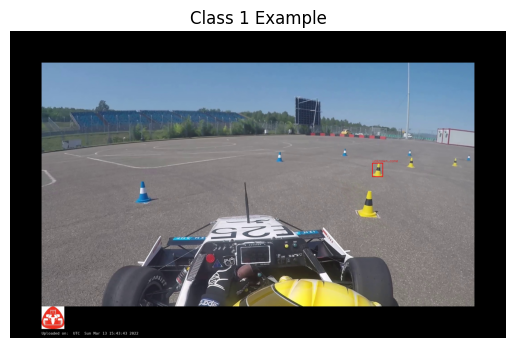

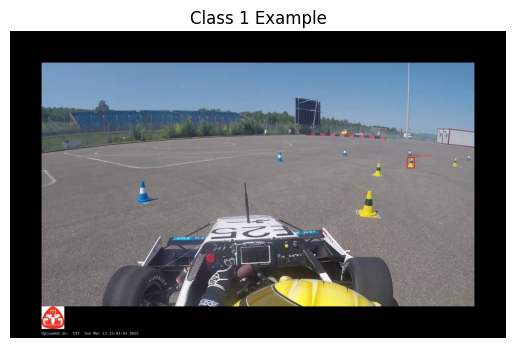

Class 0 (orange_cone): 2383 occurrences


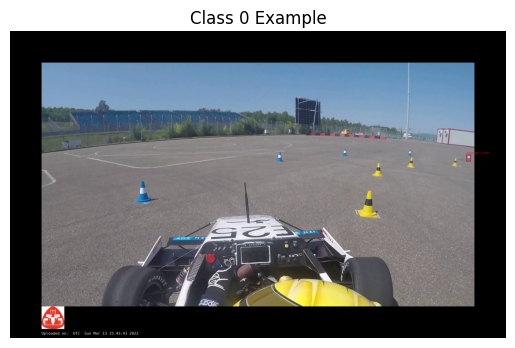

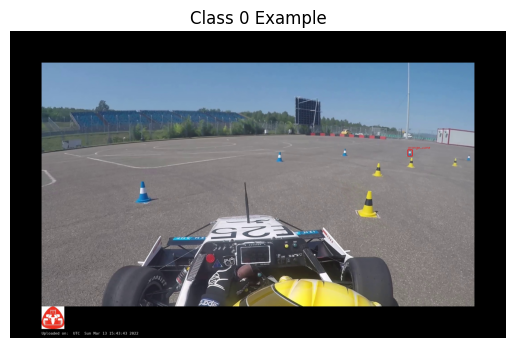

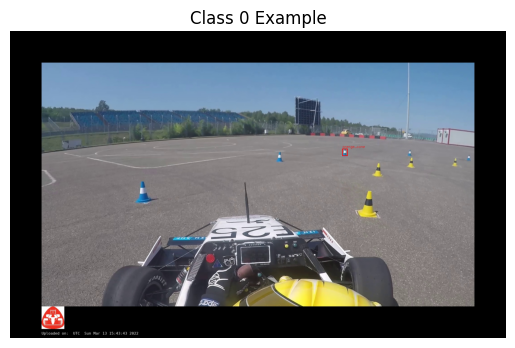

Class 3 (large_orange_cone): 423 occurrences


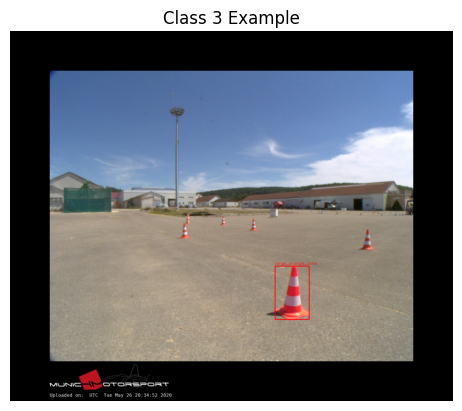

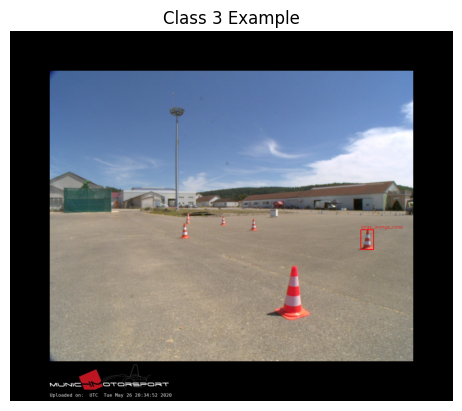

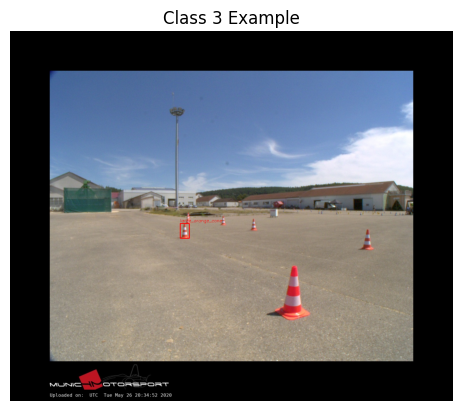

Class 4 (other): 134 occurrences


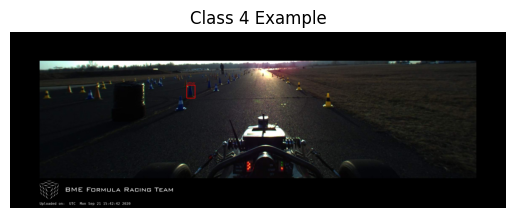

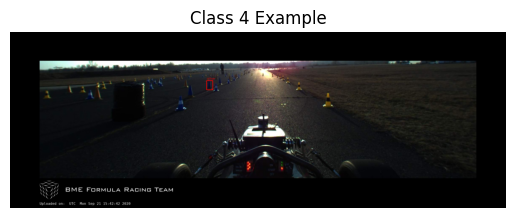

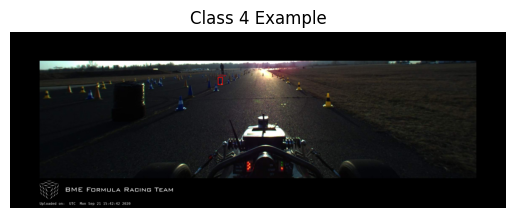

Class 2 (yellow_cone): 1088 occurrences


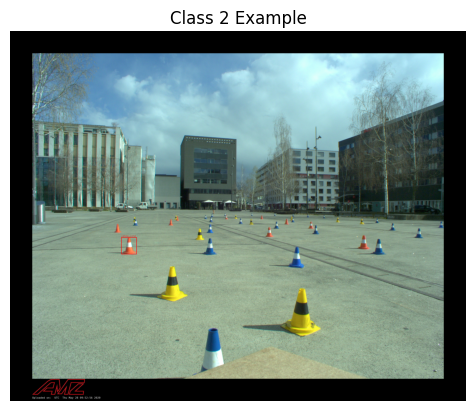

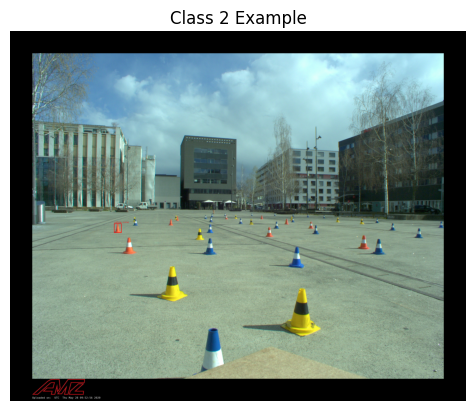

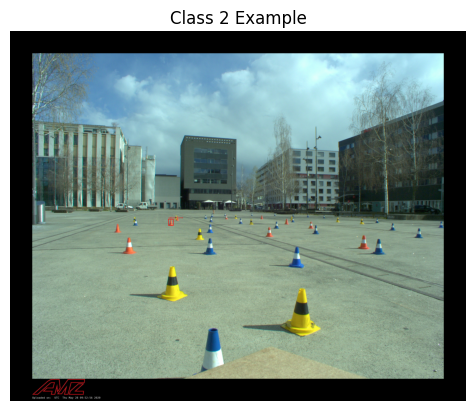

In [40]:
# Show 1–3 examples for each class
for cls_id, examples in class_examples.items():
    print(f"Class {cls_id} ({CLASS_NAMES[cls_id]}): {class_counts[cls_id]} occurrences")
    for img_path, annotation in examples:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        _, x, y, bw, bh = map(float, annotation.split())
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(img, CLASS_NAMES[cls_id], (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        plt.imshow(img)
        plt.title(f"Class {cls_id} Example")
        plt.axis('off')
        plt.show()


In [37]:
import torch 

torch.cuda.empty_cache()

from ultralytics import YOLO

model = YOLO("yolov10n.yaml")

# Train with small batch size and limited workers
results = model.train(
    data='dataset02/data.yaml',
    epochs=10,
    imgsz=640,         # Reduce image size if still OOM, try 416 or 320
    batch=2,           # Critical for low VRAM; try 1 if it still crashes
    workers=0,         # Avoid multiprocessing overhead
    device=0           # Make sure it uses the GPU
)

model.export()

New https://pypi.org/project/ultralytics/8.3.140 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.135 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce MX450, 1683MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset02/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=Fa

train: Scanning /home/uweai-ssd/perception/dataset02/train/labels... 9254 images, 2 backgrounds, 0 corrupt: 100%|██████████| 9256/9256 [00:45<00:00, 202.99it/s] 


train: New cache created: /home/uweai-ssd/perception/dataset02/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 257.0±84.7 MB/s, size: 973.8 KB)


val: Scanning /home/uweai-ssd/perception/dataset02/val/labels... 1158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1158/1158 [00:05<00:00, 200.36it/s]

val: New cache created: /home/uweai-ssd/perception/dataset02/val/labels.cache


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.539G      5.025      10.71      3.247          8        640: 100%|██████████| 4628/4628 [37:38<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:47<00:00,  2.70it/s]


                   all       1158      22113       0.32      0.104      0.104     0.0538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.619G      3.702      2.684       2.02         14        640: 100%|██████████| 4628/4628 [41:57<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:50<00:00,  2.62it/s]


                   all       1158      22113      0.609      0.147      0.167       0.09

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.633G       3.37      2.105      1.921         59        640: 100%|██████████| 4628/4628 [41:51<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:50<00:00,  2.62it/s]


                   all       1158      22113      0.656       0.17      0.187      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.648G      3.168      1.868      1.874         18        640: 100%|██████████| 4628/4628 [41:30<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:48<00:00,  2.68it/s]

                   all       1158      22113      0.684      0.173       0.21      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.664G      3.038      1.719      1.838         22        640: 100%|██████████| 4628/4628 [41:24<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:47<00:00,  2.70it/s]

                   all       1158      22113      0.691      0.187      0.218      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      0.68G      2.921      1.618      1.811         31        640: 100%|██████████| 4628/4628 [41:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:46<00:00,  2.73it/s]

                   all       1158      22113      0.704      0.196      0.228      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.695G      2.856       1.55      1.797         59        640: 100%|██████████| 4628/4628 [41:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:46<00:00,  2.71it/s]

                   all       1158      22113      0.714      0.199      0.233      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.711G      2.779      1.502      1.784         41        640: 100%|██████████| 4628/4628 [41:23<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:47<00:00,  2.69it/s]


                   all       1158      22113       0.74        0.2      0.242      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.727G      2.715      1.449      1.772         24        640: 100%|██████████| 4628/4628 [40:05<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:46<00:00,  2.72it/s]

                   all       1158      22113      0.745      0.202      0.242      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.742G      2.656       1.41      1.764         24        640: 100%|██████████| 4628/4628 [42:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:49<00:00,  2.64it/s]

                   all       1158      22113       0.75      0.202      0.249      0.153



10 epochs completed in 7.137 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 5.7MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce MX450, 1683MiB)
YOLOv10n summary (fused): 102 layers, 2,266,143 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 290/290 [01:28<00:00,  3.26it/s]


                   all       1158      22113       0.75      0.202      0.249      0.153
           orange_cone        940       8606      0.806      0.221      0.314       0.19
          unknown_cone        960       9324       0.77      0.231      0.306      0.181
           yellow_cone        460       2602       0.68      0.293       0.34      0.217
     large_orange_cone        303        842      0.492      0.265      0.273      0.171
                 other         93        739          1          0     0.0108    0.00375
Speed: 0.4ms preprocess, 28.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/train7
Ultralytics 8.3.135 🚀 Python-3.10.12 torch-2.7.0+cu126 CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
YOLOv10n summary (fused): 102 layers, 2,266,143 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'runs/detect/train7/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (5.5 MB)

TorchScript: start

'runs/detect/train7/weights/best.torchscript'

In [ ]:
metrics = model.val(data="dataset02/data.yaml", split='test')  # uses test images

# Optional: print metrics
print(metrics.box.map)      # mAP@0.5:0.95
print(metrics.box.map50)    # mAP@0.5

Ultralytics 8.3.135 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce MX450, 1683MiB)
YOLOv10n summary (fused): 102 layers, 2,266,143 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 287.4±100.4 MB/s, size: 1786.0 KB)


val: Scanning /home/uweai-ssd/perception/dataset02/test/labels... 1157 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1158/1158 [00:07<00:00, 164.90it/s]

val: New cache created: /home/uweai-ssd/perception/dataset02/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 579/579 [01:16<00:00,  7.58it/s]


                   all       1158      21639      0.789      0.342      0.406      0.249
           orange_cone        915       8283       0.85      0.443      0.548      0.336
          unknown_cone        954       9077      0.815      0.436      0.528      0.317
           yellow_cone        466       2698      0.705      0.391      0.461      0.295
     large_orange_cone        289        775      0.573      0.441       0.47      0.291
                 other        104        806          1          0     0.0252    0.00756
Speed: 0.5ms preprocess, 13.1ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/train72
0.24934807285994792
0.40645395497792264


AttributeError: 'Metric' object has no attribute 'precision'. See valid attributes below.

    Class for computing evaluation metrics for Ultralytics YOLO models.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    

In [39]:
print(metrics.box.p)
print(metrics.box.r)

[    0.85006     0.81459     0.70541     0.57281           1]
[    0.44296     0.43561      0.3914     0.44129           0]
